In [1]:
!pip install jaxlib
!pip install jax
!pip install matplotlib
!pip install diffrax


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt 


## The SIR Model

Our goal will be simulation on the SIR model, a system of three nonlinear differential equations describing disease spread. The system looks as follows:

$$
\begin{aligned}
\frac{dS}{dt} &= -\frac{\beta S I}{N} \\
\frac{dI}{dt} &= \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{aligned}
$$

with initial conditions $S(0) = S_{0}$, $I(0) = I_0$ and $R_{0} = R_{0}$ and $N = S(t) + I(t) + R(t) = S_{0} + I_{0} + R_{0} = \text{constant}$. This system describes the the spread of an infectious disease by dividing the population into three groups, Susceptibles $S(t)$, Infectious $I(t)$, and Recovered $R(t)$.
A key assumption of this model is that once a personal transitions from infected to recovered they can no longer become susceptible to disease again.

The SIR model has two constant parameters, $\beta$ and $\gamma$. These parameters do not vary with time and are fixed for the duration of the time interval of the solution. The parameter $\gamma$ is the recovery rate, with units of $\frac{1}{\text{days}}$. For instance $\gamma = 0.2$ would indicate a average duration of illness of $5$ days. $\beta$ is the transmission rate, controlling the average number of people infected by one infected person per unit time.  

## Solutions to the SIR Model

Given a known $\beta,\gamma, S_0, I_0$, and $R_0$ we would like to find a solution to the SIR model, $S(t), I(t)$, and $R(t)$ so we can observe how many people are infected, susceptible, and recovered over the course of time. Unfortunately this system of differential equations admits no closed form expression, there is no way derive $S(t),I(t)$, and $R(t)$ algebraically.

### Numerical Solutions

We instead turn to numerical solutions, the process of approximating solutions to the differential equations using computers. The simplest numerical method for approximating solutions to differential equations is Euler's method. In Euler's method we approximate the derivative using finite differences and derive an update formula as follows. 

First, we will use the compact notation $X(t) = [S(t),I(t),R(t)]^T$ and therefore $\frac{dX}{dt} = f(X(t))$ where $f = [-\frac{\beta S I}{N},\frac{\beta S I}{N} - \gamma I,\gamma I]^T$. Then we use the approximation 

$$
\begin{aligned}
\frac{dX}{dt} \approx \frac{X(t+\Delta t) - X(t)}{\Delta t}
\end{aligned}
$$

where we have substituted the concrete time step $\Delta t$ for the infinitesimal time step $dt$. The value of $\Delta t$ controls the error of the approximation. Our finite difference derivative then becomes

$$
\begin{aligned}
\frac{X(t+\Delta t) - X(t)}{\Delta t} = f(X(t)). 
\end{aligned}
$$. 

We can solve this expression for $X(t + \Delta t)$ to obtain an update formula 

$$
\begin{aligned}
X(t + \Delta t) = X(t) + \Delta t \cdot f(X(t)) 
\end{aligned}
$$. 

This formula gives us a recursion relation by which we can obtain an approximate solution to $X(t)$ on a grid of time points $[0,\Delta t, 2\Delta t, \dots]$ given a starting point $X(t_0)$.

## Coding the Numerical Solution in JAX

This section will describe how to program the numerical solution to the differential equation in the auto-differentiation python package JAX. We will first define a function `EulerStepper` that implements a single step of the Euler recursion relation. The fields will be the time step $\Delta t$ denoted `delta_t` in the code, the function $f(X(t))$, and any parameters, in our case $\beta$ and $\gamma$ in the vector `par`. 

In [3]:
def EulerStepper(x_prev,delta_t=0.01,*, par = None, func):
        x_next = x_prev + delta_t * func(x_prev,par)
        return x_next

In [4]:
step = EulerStepper(0.1,delta_t = 0.1,par = (0.1),func = lambda x,par:-par * x)

print(step)

0.099


advances an Euler approximation to the differential equation $\frac{dX}{dt} = -kX$ by one time step `delta_t` starting at $0.1$. 

The Euler approximation to our SIR model solution can be easily implemented using a for loop, which we have encapsulated in the function `solver`. 

In [5]:
steps = 1000
delta_t = 0.1
par = jnp.array([0.3,0.1]) #beta,gamma
X0 = jnp.array([100.0,1.0,0.0]) #S_0,I_0,R_0

 
def SIR_func(X,par): 
    beta,gamma = par #Unpack parameter tuple

    S,I,R = X #Unpack input array 

    N = S+I+R #Total population

    ## Derivatives ##
    dS = -beta/N * S * I
    dI = beta/N * S * I - gamma * I
    dR = gamma * I

    return jnp.array([dS,dI,dR])

def solver(delta_t,X0,par,func,steps):

    beta,gamma = par

    X = jnp.zeros((steps,X0.shape[0])) #Array to hold solution values
    X = X.at[0,:].set(X0) #JAX arrays must be set this way, numpy syntax will not work.

    ## Euler solution loop ##
    for step in range(1,steps): 
        X_next = EulerStepper(X[step-1,:],delta_t = delta_t, par = (beta,gamma), func = func)
        X = X.at[step,:].set(X_next)

    return X

X_euler = solver(delta_t,X0,par,SIR_func,steps)

We can now plot the solution using the plotting package matplotlib. For the SIR model, the Euler method actually provides a pretty good approximation to the solution!

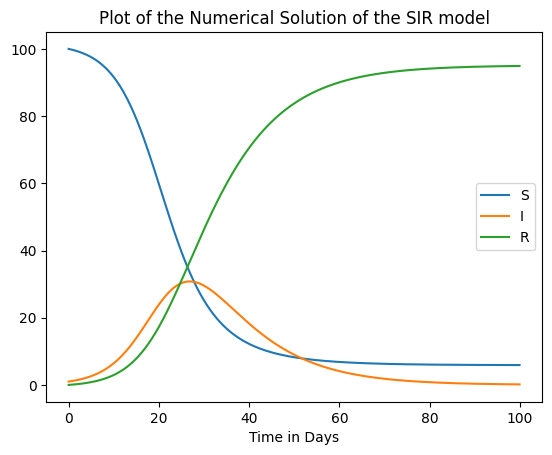

In [6]:
labels = ['S','I','R']
t_range = jnp.arange(0,steps * delta_t,delta_t)

plt.title('Plot of the Numerical Solution of the SIR model')
for i in range(X0.shape[0]): 
    plt.plot(t_range,X_euler[:,i],label = labels[i])

plt.xlabel('Time in Days')
plt.legend()
plt.show()

## Exercises 

Evaluate the effect of changing `delta_t` on the solution. In particular, choose different values of `delta_t` and graph the resultant $I(t)$ curve for each `delta_t` on the same plot. 

Evaluate the effect of changing $\beta$ and $\gamma$. Plot the results of keeping `gamma` fixed and changing `beta` and the results of keeping `beta` fixed and changing `gamma`. What happens if $\gamma > \beta$?

## Inverse Problems

In the previous section, we solved what is called the forward problem. Given initial conditions $S_{0},I_{0}$, and $R_{0}$ and parameters $\beta = 0.3$ and $\gamma = 0.1$ we found the approximate solution to $S(t),I(t)$, and $R(t)$. However it is common in real world scenarios that we actually know the infection curve $I(t)$ or at least have a noisy estimate. Agencies such as the CDC publish the reported cases(or hospitalizations) which we can use for analysis. 

The inverse problem then becomes the following. Given an estimate of the infection curve $\{y_1,y_2,\dots,y_T\}$ what are the most likely values of $\beta$ and $\gamma$ to have produced this curve? Our data is usually given daily or weekly for disease, so $T$ is the last day or week of data. 

### Example 

For our example lets take the solution of the SIR model we produced in the last example, extract the $I(t)$ curve and add some noise to simulate real data. 

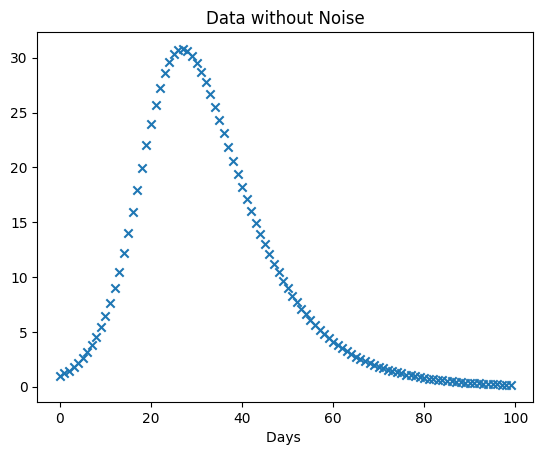

In [7]:
## We extract the I compartment value at daily intervals to simulate our daily data. 1/delta_t is the number of delta_t intervals in one day. 

I = X_euler[:,1]
day_interval = int(1/delta_t)

data = I[::day_interval] ## Extracts every day_interval element from I

day_range = jnp.arange(0.,steps//day_interval,1.)

plt.title('Data without Noise')
plt.scatter(day_range,data,marker = 'x')
plt.xlabel('Days ')
plt.show()

Now lets add some noise. We will add Poisson distributed noise here which satisfies some nice assumptions. 

1. The data is integer valued. (No fractional infection is reported, doesn't make sense!)
2. The data is always greater than zero. (No negative infections.)
3. The noise for each data point is uncorrelated. 

We will use JAX's syntax for generating random numbers. This is slightly different from traditional stateful PRNG and worth reading about on the JAX website. 
I'll mention the basics. 

In [8]:
'''JAX PRNG keys are generated using this function, a seed can be provided for reproducibility. 
You can choose the method for generating pseudo-random numbers but for our use case the default will suffice. '''
rng_key = jax.random.key(0) 

'''To generate random numbers we feed the key into a jax.random function.'''

num = 10

rand_nums = jax.random.uniform(rng_key,minval = 0.,maxval = 1.,shape = (num,))
print(rand_nums,"\n")

'''We have generated an array of 10 uniform random number between 0 and 1.
Let's try to generate a second array.'''

rand_nums2 = jax.random.uniform(rng_key,minval = 0.,maxval = 1., shape = (num,))
print(rand_nums2)

'''The same array!'''

[0.947667   0.9785799  0.33229148 0.46866846 0.5698887  0.16550303
 0.3101946  0.68948054 0.74676657 0.17101455] 

[0.947667   0.9785799  0.33229148 0.46866846 0.5698887  0.16550303
 0.3101946  0.68948054 0.74676657 0.17101455]


'The same array!'

In JAX, the state of the random number generator corresponding to a key is not updated as in NumPy. A JAX key will give you the same sequence of numbers every single time you call it, which is oftentimes not what you want. 

In JAX a key should be used only once in a `jax.random` function and then discarded. We instead generate new keys based on the value of the old key to maintain reproducibility. 

In [9]:
rng_key = jax.random.key(5) 

'''Split the key, get two new keys. One will be our global key for future splitting, the other the key to use for generation.'''
rng_key,rand_key = jax.random.split(rng_key)

num = 10

rand_nums = jax.random.uniform(rand_key,minval = 0.,maxval = 1.,shape = (num,))
print(rand_nums,"\n")

del rand_key #Just to indicate we don't want to use this key again. You don't need to delete it!

rng_key,rand2_key = jax.random.split(rng_key)

rand_nums2 = jax.random.uniform(rand2_key,minval = 0.,maxval = 1., shape = (num,))

del rand2_key

print(rand_nums2)

[0.08381331 0.22921324 0.11234713 0.2685336  0.12162471 0.45548236
 0.53602886 0.47860444 0.16304624 0.07066178] 

[0.082425   0.5812527  0.8699739  0.23379648 0.8386893  0.06594062
 0.4907614  0.07678306 0.31049514 0.2610916 ]


Now we have two arrays of random numbers just as we wanted. The rule of thumb to follow is once you use the JAX key, discard it. Never use it to generate random numbers again!

Now, adding noise to our data. 

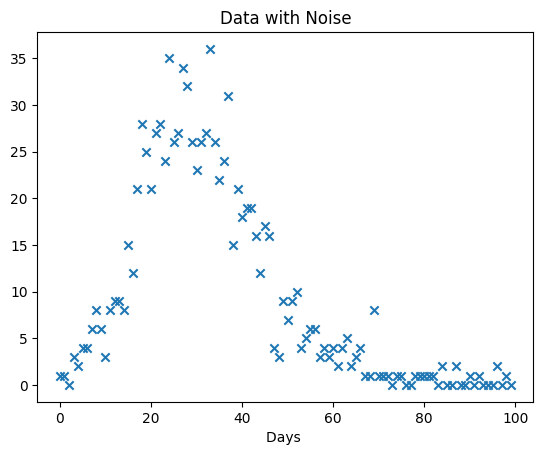

In [10]:
rng_key,noise_key = jax.random.split(rng_key)

data = jax.random.poisson(noise_key,data)

del noise_key

plt.title('Data with Noise')
plt.scatter(day_range,data,marker = 'x')
plt.xlabel('Days ')
plt.show()

Good, now our data is noisy and reflective of real world data with reporting errors and random anomalies. 

### The Likelihood Function

The next question to address is how to relate the observed data to the model. We construct a likelihood function based on our assumptions about the data. 

Assume our data $y_{t}$ is Poisson distributed with mean equal to the true value $I(t)$ and note that $I(t)$ depends on our choice of parameters $\beta$ and $\gamma$. We will write $\theta = [\beta, \gamma]^T$ and note the dependence of $I(t)$ on $\theta$ by $I_{\theta}(t)$. Now for each data point 
$$
Y_{t} \sim f(\cdot|I_{\theta}(t))
$$

where $f(X|I_{\theta}(t))$ is a Poisson distribution with mean $I_{\theta}(t)$. So $Y_{t}$ is a random variable with distribution 

$$
P(Y_{t} = y_{t}) = f(y_{t}|I_{\theta}(t)) = \frac{(I_{\theta}(t))^{y_t} e^{-(I_{\theta}(t))}}{y_{t}!}.
$$
The probability $Y_{t}$ takes on the value $y_{t}$ is given by the above expression. This probability mass function is implemented simply in `jax.scipy.stats` as
`poisson`. 

We now make one last assumption. We assume each observation is independent, that considering other observations does not change the probability of $Y_t$. 
This can be expressed in the following way 
$$
P(Y_t = y_t,Y_{k} = y_{k}) = P(Y_t = y_{t})P(Y_{k} = y_{k}), k \neq t
$$. 

This means that we can nicely formulate our full likelihood function as 

$$
L(\theta) = P(Y_{0:T} = y_{0:T}) = \prod\limits_{t=0}^{T} f(y_{t}|I_{\theta}(t))
$$

where $Y_{0:T}$ is notation meaning $Y_{0},Y_{1},\dots,Y_{T}$. The meaning of this function is that the probability we see $Y_{0} = y_{0}$ and $Y_{1} = y_{1}$ and $\dots$ and $Y_{T} = y_{T}$ is equal to the expression on the right. 

One final note, we introduce the notation $L(\theta)$ to indicate that the solution to $I_{\theta}(t)$ and thus $P(Y_{0:T} = y_{0:T})$ can be thought of as a function of $\theta$. 

Our goal is now more clear. We want to find the value of $\theta$ that maximizes $L(\theta)$. If $L(\theta)$ is maximized this corresponds to maximizing the probability that our data occurs given $\theta$. This is called the maximum likelihood estimate(MLE) of $\theta$ which we will denote $\theta^{*}$. 

### Finding the Maximum Likelihood Estimate of $\theta$

Before continuing we will use a trick to simplify computation. We take the log of $L(\theta)$ which we denote $\mathcal{L}(\theta)$. The properties of the logarithm allow us to simplify our expression and the fact that $\log$ is monotonic means the maximum of $L(\theta)$ is equal to the maximum of $\mathcal{L}(\theta)$. This step is important because each element in the product in $L(\theta)$ is between $0$ and $1$. The product of many small numbers becomes very small, sometimes too small for the computer to represent! So this trick alleviates that issue. 

$$
\mathcal{L}(\theta)  = \log(L(\theta)) = \log\left(\prod\limits_{t=0}^{T} f(y_{t}|I_{\theta}(t))\right) \\
                     = \sum\limits_{t=0}^{T} \log(f(y_{t}|I_{\theta}(t)))
$$

Now we work exclusively with $\mathcal{L}(\theta)$. Because $\mathcal{L}(\theta)$ has a two dimensional range we can actually plot it. 

In [11]:
##First lets define our log-likelihood function 

@jax.jit
def log_likelihood(theta): 
    day_interval = int(1/delta_t)
    X = solver(delta_t = delta_t,par = theta,X0 = X0, func = SIR_func,steps = steps) #Solve the system with the given theta
    I = X[::day_interval,1]
    I = jnp.clip(I, 1e-8, None) #Clip just in case I dips below zero

    return jnp.sum(jax.scipy.stats.poisson.logpmf(k = data, mu = I))

print(f"Log likelihood test: {log_likelihood(jnp.array([0.1,0.1]))}")

Log likelihood test: -2082.894775390625


In [12]:
betas = jnp.arange(0,0.5,0.01) #Grid for betas
gammas = jnp.arange(0,0.5,0.01) #Grid for gammas

LL = jnp.zeros((len(betas), len(gammas))) #Array to store log-likelihood values

## Iterate over every (beta,gamma) pair and evaluate log-likelihood 
for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        theta = jnp.array([beta, gamma])
        LL = LL.at[i, j].set(log_likelihood(theta))


beta* = 0.29999998
gamma* = 0.099999994
max log-likelihood = -206.35555


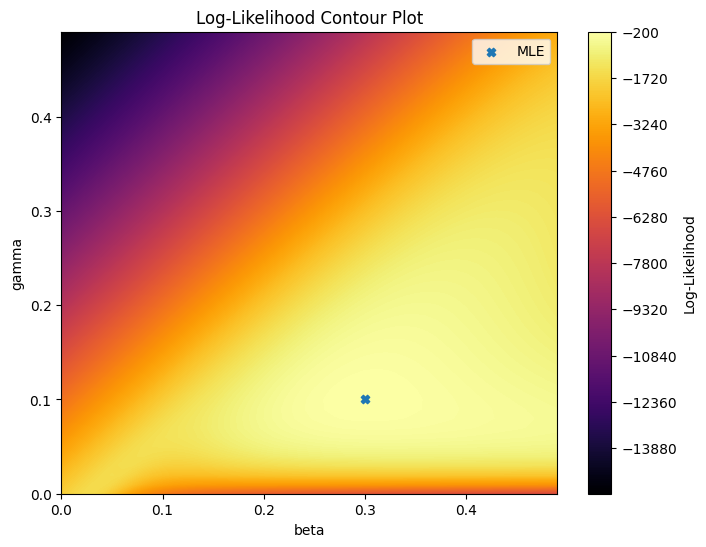

In [13]:
## Find the argmaximum in the grid
idx = jnp.argmax(LL)
i, j = jnp.unravel_index(idx, LL.shape)

beta_star  = betas[i]
gamma_star = gammas[j]
max_LL = LL[i, j]

print("beta* =", beta_star)
print("gamma* =", gamma_star)
print("max log-likelihood =", max_LL)

## Plotting the log-likelihood as the heatmap

X,Y = jnp.meshgrid(betas,gammas)

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, LL.T, levels=1000,cmap = 'inferno')
plt.colorbar(cp, label='Log-Likelihood')
plt.scatter(beta_star,gamma_star,marker = 'X',label = 'MLE')

plt.xlabel("beta")
plt.ylabel("gamma")
plt.title("Log-Likelihood Contour Plot")
plt.legend()

plt.show()

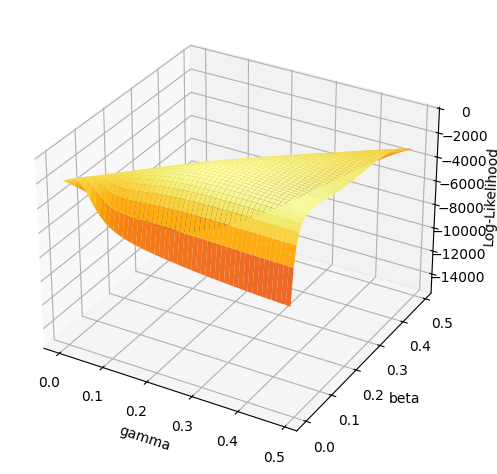

In [14]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('Log-Likelihood')
ax.plot_surface(X,Y,LL.T,cmap = 'inferno')
fig.tight_layout()

plt.show()

From the heatmap we see the MLE is exactly at the value of the parameters we used when generating the data! So we have succeeded in our estimation task, right? Well yes and no. In most problems of interest there are many more parameters and performing a grid search prohibitively expensive. 

Exercises: 

1. Try other likelihood functions than Poisson. In particular, try Gaussian and Negative Binomial distributions and see how the geometry of the likelihood surface changes. Keep in mind that the Gaussian distribution has an another parameter $\sigma$, the standard deviation. Similarly, the Negative Binomial distribution has an addition parameter $\R$, the so called overdispersion when parameterized in terms of its mean. 

2. Change the amount of data and examine how the likelihood function changes, maintaining the Poisson assumption. For example, change the data resolution to weekly or decrease the number of days of data collection.  

### Gradient based Optimization

As $\mathcal{L}(\theta)$ is nice and differentiable we can find $\theta^{*}$ as the solution to the following equation

$$
\nabla \mathcal{L}(\theta) = \bar{0}
$$

solving for $\theta$. The gradient is taken with respect to $\theta$, so $\nabla \mathcal{L}(\theta) = [\frac{\partial \mathcal{L}}{\partial \beta},\frac{\partial \mathcal{L}}{\partial \gamma}]$ and $\bar{0} = [0,0]^T$. This is typically done iteratively, taking a small step along the gradient vector and evaluating $\mathcal{L}(\theta)$ at the new point. We then continue until a suitable convergence criteria is reached. 

To utilize gradient based optimization, we need to make a modification to our function `solver` which we are using to solve the SIR model numerically. The autodifferentiation compute graph in JAX has a hard time computing stable gradients through long loops. So we will switch our solver to an external library `diffrax` which implements highly sophisticated ODE solvers and through which stable gradients can be computed. 

In [15]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt

def diffrax_solver(delta_t,X0,par,func,steps):

    term = ODETerm(lambda t,X,par: func(X,par))
    solver = Dopri5()
    times = jnp.arange(0,int(steps * delta_t),1.)
    saveat = SaveAt(ts = times)

    sol = diffeqsolve(terms = term,solver = solver,t0 = times[0],t1 = times[-1],dt0 = delta_t,y0 = X0, args = par,saveat = saveat)
    
    return sol.ys 

### Using our updated solver
X_new = diffrax_solver(delta_t,X0,par,SIR_func,steps)

##Now lets redefine our likelihood function with the new solver. 
def log_likelihood(theta): 
    delta_t = 0.1
    X = diffrax_solver(delta_t = delta_t,par = jnp.exp(theta),X0 = X0, func = SIR_func,steps = steps) #Solve the system with the given theta
    I = X[:,1] #We don't need the sampling step anymore. We told diffrax to save only at daily intervals.
    I = jnp.clip(I, 1e-8, None) #Clip just in case I dips below zero

    return jnp.sum(jax.scipy.stats.poisson.logpmf(k = data, mu = I))

print(f"Log likelihood test: {log_likelihood(jnp.array([0.1,0.1]))}")

Log likelihood test: -5397.85888671875


Now we can easily use `JAX` to obtain the gradient of our log-likelihood $\mathcal{L}(\theta)$. Note we also utilize a trick to ensure our value of theta is always positive. We perform our search over $\log(\theta)$ then exponentiate before plugging it into the solver. This transforms our constrained optimization problem into a unconstrained optimization problem in $\log$ space. This is because plugging any real number into $e^\theta$ will yield a positive number, and because $e^\theta$ is continuous with continuous derivatives we can compute gradients for any value of $\theta$. 

In [16]:
grad_LL = jax.grad(log_likelihood)
print(grad_LL(jnp.array([jnp.log(0.3),jnp.log(0.1)])))


[16.944235   4.2417445]


Exercise 1: 

Implement gradient ascent to find the maximum of the log_likelihood function. This will be 4-5 lines of code inside a loop. 

Exercise 2: 

Extend the code to SIHR model and try to estimate the parameters using the same gradient ascent setup as above. 